# Genetic Correlation Plots

In [1]:
import glob
import itertools as it 
import os
import sys
from textwrap import wrap

from adjustText import adjust_text
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns
sns.set(rc={'font.sans-serif':'Helvetica'})
sns.set(style='whitegrid', rc={'font.sans-serif':'Helvetica'})

from IPython.display import display, HTML

%matplotlib inline

In [2]:
phenos = pd.read_table('../../h2-estimation/data/traits.tsv', index_col=0)
phenos = phenos[phenos.phenotype.isnull() == False]

In [3]:
corrs = pd.read_table('../../h2-estimation/private_output/ukb_stan/combined/vtu_opt_100_0.5.tsv.gz',
                      index_col=0)
corrs = corrs[(corrs['p1_category'].isnull() == False) & 
              (corrs['p2_category'].isnull() == False)]
corrs = corrs[(corrs['p1_category'].isin(['INI', 'HC'])) & 
              (corrs['p2_category'].isin(['INI', 'HC']))]
corrs_p = corrs.pivot(index='p1_code', columns='p2_code', values='omegacor21')
for pheno in set(corrs_p.index) - set(corrs_p.columns):
    corrs_p[pheno] = np.nan
corrs_p = corrs_p.T
for pheno in set(corrs_p.index) - set(corrs_p.columns):
    corrs_p[pheno] = np.nan
corrs_p = corrs_p.T
corrs_p = corrs_p.loc[corrs_p.columns]
for p in corrs_p.index:
    corrs_p.loc[p, p] = 1
corrs_p = pd.DataFrame(np.triu(corrs_p) + np.triu(corrs_p,1).T, 
                       index=corrs_p.index, columns=corrs_p.columns)

In [4]:
def plot_corrs(ps, ax):
    tdf = corrs_p.loc[ps, ps]
    ax = sns.heatmap(tdf, ax=ax, vmin=-1, vmax=1)
    xtl = [x.replace('_', ' ') for x in phenos.loc[tdf.index, 'phenotype']]
    ax.set_xticklabels(
        xtl,
        rotation=30, 
        fontsize=fs, 
        ha='right',
    )
    ytl = [x.replace('_', ' ') for x in phenos.loc[tdf.index, 'phenotype']][::-1]
    ax.set_yticklabels(
        ytl,
        rotation=0, 
        fontsize=fs,
    )
    ax.set_xlabel('')
    ax.set_ylabel('')
    cb = ax.collections[0].colorbar
    cb.set_label("Genetic correlation", fontsize=fs)
    for t in cb.ax.get_yticklabels():
        t.set_fontsize(8)
    return(ax)

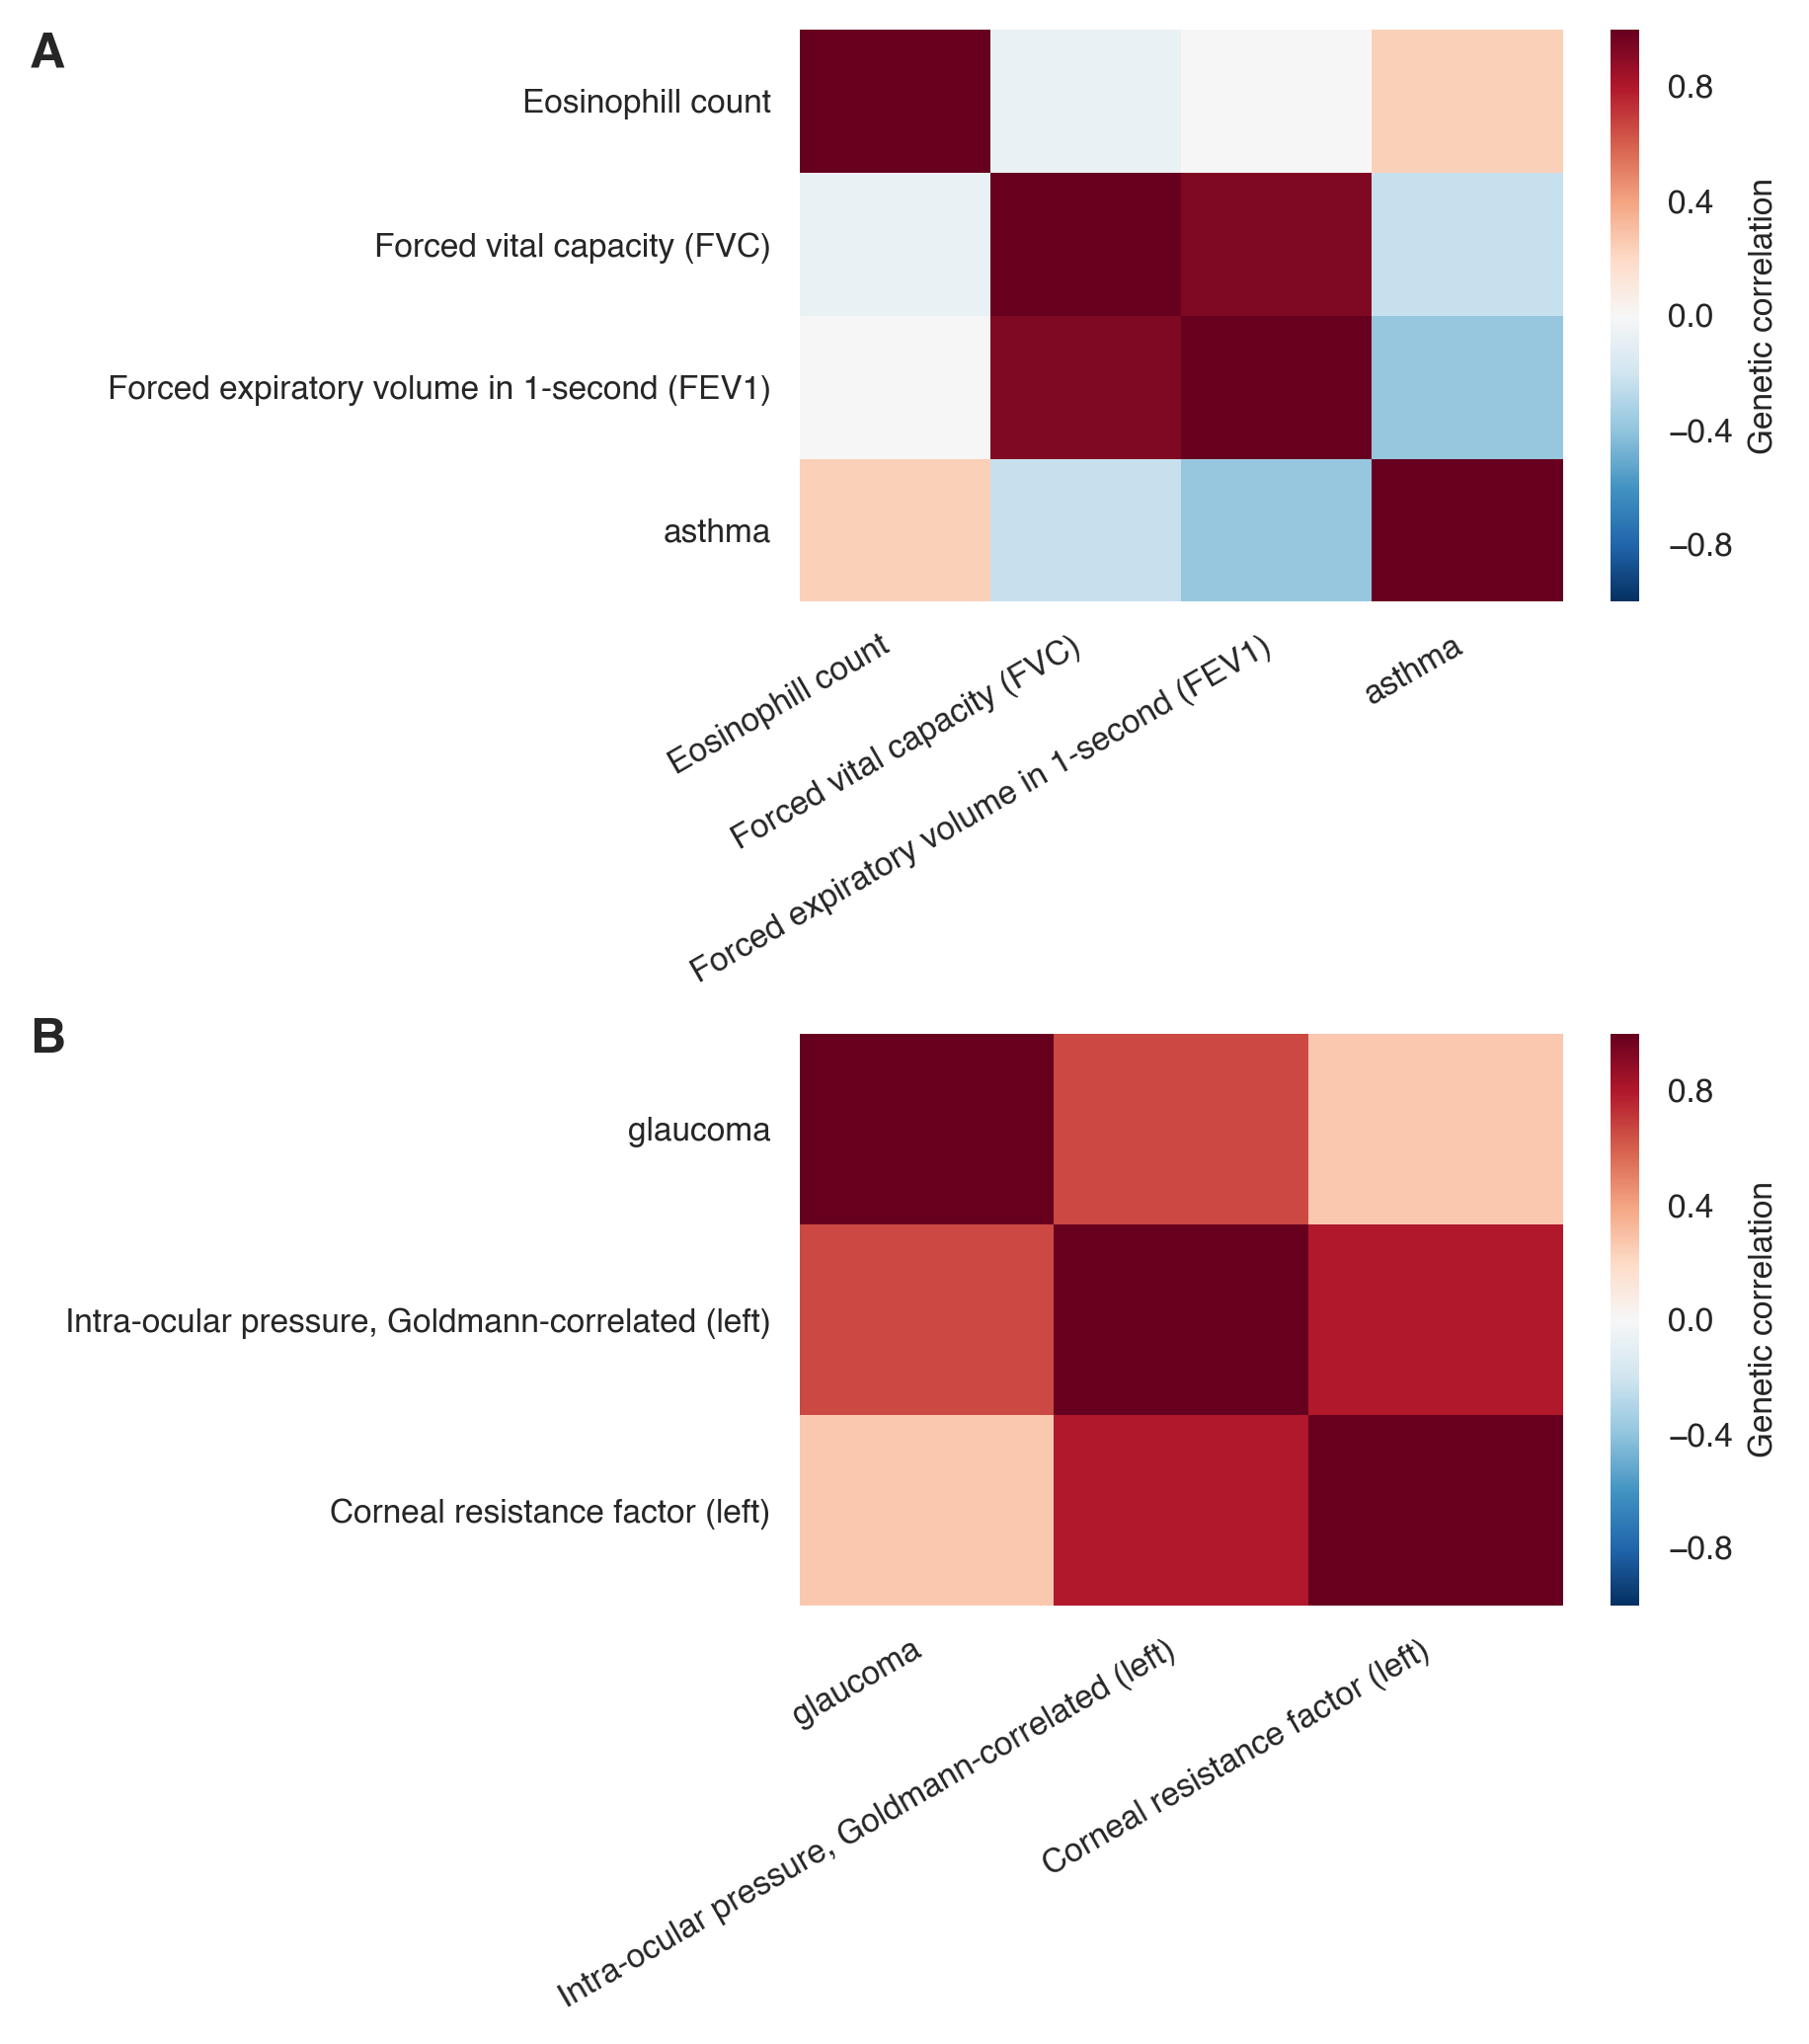

In [5]:
fs = 8

fig = plt.figure(figsize=(6, 7), dpi=300)

gs = gridspec.GridSpec(2, 1)

ax = fig.add_subplot(gs[0, 0])
ps = ['INI30150', 'INI3062', 'INI3063', 'HC382']
ax = plot_corrs(ps, ax)

ax = fig.add_subplot(gs[1, 0])
ps = ['HC276', 'INI5263', 'INI5265']
ax = plot_corrs(ps, ax)

t = fig.text(0.005, 0.96, 'A', weight='bold', 
             size=12)
t = fig.text(0.005, 0.485, 'B', weight='bold', 
             size=12)

gs.tight_layout(fig, rect=[0, 0, 1, 1])
plt.savefig('genetic_correlations.pdf')